<a href="https://colab.research.google.com/github/anantrajjadhav/Project-Group6/blob/main/Elevation%20data%20for%20IMD%20points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: for each index in unique_latlong get elevation

from google.colab import userdata
import ee
import pandas as pd
import gzip
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import gzip

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project=userdata.get('EE'))

# Import required libraries

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-anantrajjadhav')


with gzip.open('imd_daily_train.csv', 'rt') as f:
  df = pd.read_csv(f)

# Assuming 'pos' column contains coordinates in '(latitude, longitude)' format
df[['latitude', 'longitude']] = df['pos'].str.split(',', expand=True)

# Remove parentheses and extra spaces
df['latitude'] = df['latitude'].str.replace('(', '', regex=False).str.strip()
df['longitude'] = df['longitude'].str.replace(')', '', regex=False).str.strip()

# Convert latitude and longitude to numeric if needed
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])

# Select only latitude and longitude columns
df = df[['latitude', 'longitude']]

# Find unique latitude and longitude pairs
unique_latlong = df[['latitude', 'longitude']].drop_duplicates()

unique_latlong

# Load the DEM dataset
dem = ee.Image('USGS/SRTMGL1_003')  # SRTM DEM

# Calculate terrain characteristics
terrain = ee.Terrain.products(dem)
elevation = dem.select('elevation')


# Create an empty list to store the results
results = []

# Loop through unique latitude and longitude pairs
for index, row in unique_latlong.iterrows():
  latitude = row['latitude']
  longitude = row['longitude']

  # Define the point geometry
  point = ee.Geometry.Point([longitude, latitude])

  # Reduce region to get values at the point
  elevation_val = elevation.reduceRegion(
      reducer=ee.Reducer.mode(),
      geometry=point,
      scale=500
  ).get('elevation').getInfo()

  # Append the results to the list
  results.append({
      'Longitude': longitude,
      'Latitude': latitude,
      'Elevation': elevation_val
  })

# Convert the results list to a Pandas DataFrame
df_results = pd.DataFrame(results)
print(df_results)
# Save to CSV
csv_filename = 'terrain_characteristics_all.csv'
df_results.to_csv(csv_filename, index=False)
print(f"CSV file saved: {csv_filename}")

     Longitude  Latitude  Elevation
0         76.5      10.5        332
1         77.5      10.5        295
2         78.5      10.5        164
3         79.5      10.5          7
4         75.5      11.5          0
..         ...       ...        ...
295       77.5      35.5       5417
296       77.5       8.5        502
297       76.5       9.5          2
298       77.5       9.5        190
299       78.5       9.5         46

[300 rows x 3 columns]
CSV file saved: terrain_characteristics_all.csv


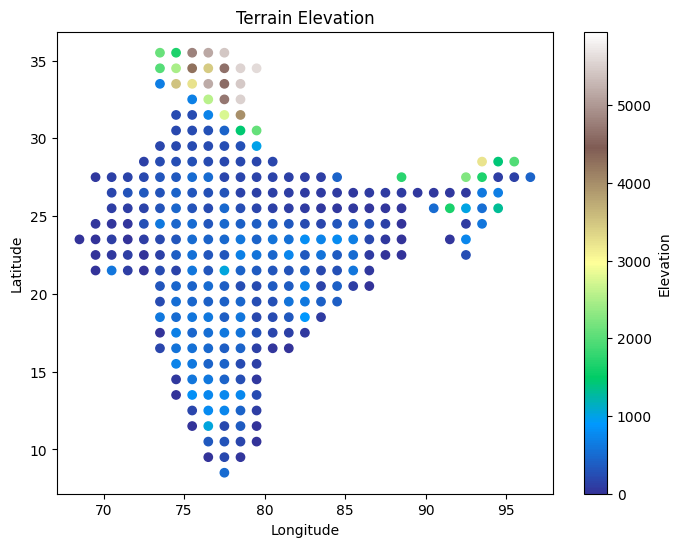

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/terrain_characteristics_all.csv')

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Elevation'], cmap='terrain')
plt.colorbar(label='Elevation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Terrain Elevation')
plt.show()